In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from NeuralNetwork import NeuralNetwork
from functions import *
from Layer import Layer, Input
from utils import *

In [2]:
names = ['id', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 
         'feature_7', 'feature_8', 'feature_9', 'feature_10', 'target_x', 'target_y','target_z']

df = pd.read_csv("/Users/HP/Desktop/UNI/LM_1/MachineLearning/ML_prj/data/ML-CUP23-TR.csv", names=names, comment='#')

In [3]:
targets = ['target_x', 'target_y', 'target_z']
features = list(set(names) - {'id', 'target_x', 'target_y', 'target_z'})

In [4]:
df = df.sample(frac=1)

In [5]:
prova = df[0:750]


In [6]:
X_train, y_train = prova[features].to_numpy().T, prova[targets].to_numpy().T
X_test, y_test = df[750:][features].to_numpy().T, df[750:][targets].to_numpy().T

In [7]:
X_train.shape

(10, 750)

In [8]:
early_stopping = {'patience' : 150,
                  'monitor' : 'val_MRAE',
                  'verbose' : 0,
                  'compare_function': np.greater_equal}

reduce_eta = {'patience' : 75,
              'monitor' : 'val_MRAE',
              'factor' : 0.5,
              'verbose' : 0,
              'compare_function': np.greater_equal}

callbacks = {'early_stopping': None,
             'reduce_eta': None}

In [9]:
train_params = {
    'hidden_dim' : 20,
    'hidden_act_func' : 'sigm',
    'hidden_dim2' : 20,
    'hidden_act_func2' : 'relu',
    'eta' : 0.09,
    'lam' : 0.00,
    'alpha' : 0.95,
    'n_batch': 128,
    'use_opt': 1,
}
params = train_params.copy()
input_layer = Input(10)
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
hidden_layer = Layer(hidden_layer, params.pop('hidden_dim2'), params.pop('hidden_act_func2'))
#hidden_layer = Layer(hidden_layer, 5, 'sigm')
output_layer = Layer(hidden_layer, 3, 'lin')

model = NeuralNetwork(input_layer, output_layer, loss = 'MSE', metrics=[MEE])
history = model.train(X_train, y_train, epochs = 200,
                                    ** params,
                                    validation_split = 0.2,
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 5.214e+02, val_loss: 5.922e+02; train_MEE: 3.651e+01, val_MEE: 3.876e+01  lr : 0.09
Epoch 1: train_loss: 3.275e+02, val_loss: 3.530e+02; train_MEE: 2.951e+01, val_MEE: 3.054e+01  lr : 0.09
Epoch 2: train_loss: 1.671e+02, val_loss: 1.933e+02; train_MEE: 2.090e+01, val_MEE: 2.230e+01  lr : 0.09
Epoch 3: train_loss: 1.034e+02, val_loss: 1.054e+02; train_MEE: 1.629e+01, val_MEE: 1.655e+01  lr : 0.09
Epoch 4: train_loss: 7.363e+01, val_loss: 8.154e+01; train_MEE: 1.370e+01, val_MEE: 1.453e+01  lr : 0.09
Epoch 5: train_loss: 4.862e+01, val_loss: 6.764e+01; train_MEE: 1.121e+01, val_MEE: 1.292e+01  lr : 0.09
Epoch 6: train_loss: 4.055e+01, val_loss: 5.848e+01; train_MEE: 1.011e+01, val_MEE: 1.162e+01  lr : 0.09
Epoch 7: train_loss: 3.066e+01, val_loss: 3.777e+01; train_MEE: 8.944e+00, val_MEE: 9.669e+00  lr : 0.09
Epoch 8: train_loss: 2.196e+01, val_loss: 3.107e+01; train_MEE: 7.331e+00, val_MEE: 8.364e+00  lr : 0.09
Epoch 9: train_loss: 1.734e+01, val_loss: 2.534e+01; tr

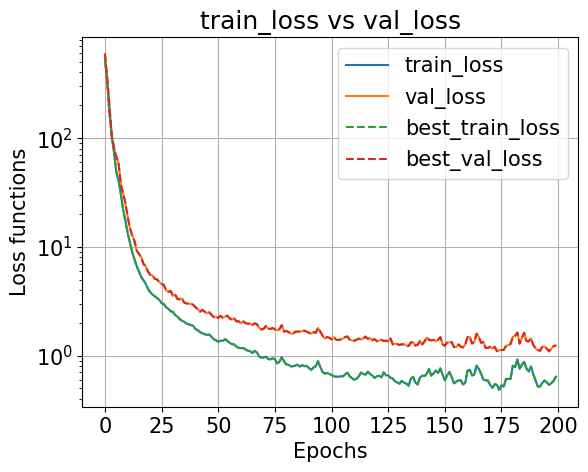

In [13]:
plt.plot(history['train_loss'],label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.plot(best_train_loss, '--', label='best_train_loss')
plt.plot(best_val_loss, '--', label='best_val_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs val_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

In [12]:
best_params = train_params
best_train_loss = history['train_loss']
best_val_loss = history['val_loss']

In [ ]:
plt.plot(history['train_MRAE'],label='train_MRAE')
plt.plot(history['val_MRAE'], label='val_MRAE')
plt.xlabel('Epochs', size=15)
plt.ylabel('MRAE', size=15)
plt.title('train_MRAE vs val_MRAE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

KeyError: 'train_MRAE'

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
def MRAE(y_pred, y_true):
    return (np.abs((y_pred - y_true)/y_true)/y_true.shape[1]).reshape(y_pred.shape)

In [ ]:
print(MRAE(y_pred, y_test).sum(axis=1))

[0.17134048 0.41987499 0.17962694]


In [ ]:
y_pred

array([[-4.82014940e+01, -1.21765954e+01,  6.72478599e+00,
         1.53731827e+01, -1.22375210e-02,  3.59401642e-01,
        -5.69870533e+01,  1.54983848e+01, -4.06117601e+00,
        -4.69271368e+01, -8.83137738e+00, -2.44062616e+01,
        -3.04445933e+01,  3.57653955e+00,  1.18805865e+01,
         3.83829002e+00, -6.25414144e-01, -6.17813255e+01,
        -1.37919555e+01,  4.52263920e+00, -3.90078463e+01,
         3.54567422e+00, -4.86872802e+01, -1.67295796e+01,
         1.20624276e+00, -4.53113428e+01,  2.22694352e+00,
         4.61185107e+00,  2.18810487e+00,  1.69879662e+00,
        -6.14052933e+01, -6.40553309e+01, -2.32152071e+01,
        -3.70747802e+01, -5.73955264e+01, -3.54470435e+01,
         6.47428002e-01,  4.73064307e+00, -5.11761979e+01,
        -1.84354714e+01,  7.17102522e+00, -3.40374054e+01,
         7.23920374e+00,  4.55919672e+00, -2.71977261e+01,
        -5.46631537e+01,  7.94195723e+00, -3.29880349e+01,
         7.73506715e+00, -4.66277772e+01,  1.04685745e+0

In [ ]:
y_test

array([[-4.91707340e+01, -1.18971060e+01,  6.97887000e+00,
         1.54351920e+01, -2.45094900e-01,  4.03467400e-01,
        -5.87634120e+01,  1.58288870e+01, -3.01825760e+00,
        -4.66138040e+01, -7.72302340e+00, -2.42441840e+01,
        -3.03221990e+01,  4.12125160e+00,  1.22751520e+01,
         3.30147430e+00, -1.85525400e+00, -6.31271400e+01,
        -1.31329120e+01,  4.80903670e+00, -3.78341100e+01,
         3.19164600e+00, -4.87959820e+01, -1.78932130e+01,
         1.38755380e+00, -4.49677350e+01,  1.90563860e+00,
         4.22560400e+00,  2.04188350e+00,  1.36303590e+00,
        -6.32393260e+01, -6.44570700e+01, -2.27842860e+01,
        -3.70299000e+01, -5.69650540e+01, -3.52268900e+01,
         1.49135900e+00,  3.84862610e+00, -5.15499530e+01,
        -1.95448250e+01,  7.06292870e+00, -3.51479640e+01,
         7.73133300e+00,  4.82422730e+00, -2.72254370e+01,
        -5.36919000e+01,  7.89745300e+00, -3.17605300e+01,
         7.71923830e+00, -4.70271200e+01,  1.04316050e+0

In [ ]:
a = np.array([[1,1,1],[1,1,1]])
print(a.sum())

6
